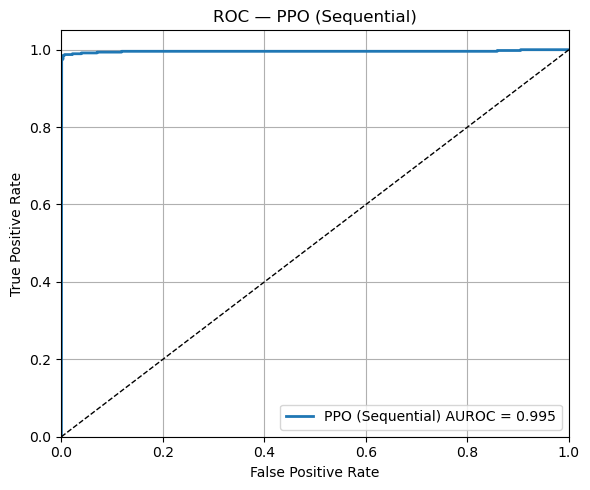

Sequential PPO AUROC: 0.995452


In [ ]:
# =========================
# 10) ROC Curve — PPO (Sequential) ONLY (Save at 300 DPI)
# =========================
from sklearn.metrics import roc_curve, auc
from stable_baselines3.common.utils import obs_as_tensor
import torch as th

# Collect probabilities for "late" (class=1)
eval_env_roc = SequentialPPOEnv(base_inputs, labels_sorted, episodes, K=5)
obs, _ = eval_env_roc.reset()

seq_probs = []
visited_episodes = 0

while True:
    # --- get action probabilities ---
    obs_batched = np.expand_dims(obs, axis=0).astype(np.float32)
    obs_tensor = obs_as_tensor(obs_batched, ppo_model_seq.device)
    with th.no_grad():
        try:
            dist = ppo_model_seq.policy.get_distribution(obs_tensor)
        except AttributeError:
            latent_pi, _, _ = ppo_model_seq.policy._get_latent(obs_tensor)
            dist = ppo_model_seq.policy._get_action_dist_from_latent(latent_pi)
        prob_action1 = float(dist.distribution.probs.detach().cpu().numpy()[0, 1])
    seq_probs.append(prob_action1)

    # Step the environment
    action, _ = ppo_model_seq.predict(obs, deterministic=True)
    obs, _, terminated, truncated, _ = eval_env_roc.step(action)

    if terminated:
        visited_episodes += 1
        if visited_episodes >= len(episodes):
            break
        obs, _ = eval_env_roc.reset()

# Ensure correct length
seq_probs = np.asarray(seq_probs[:len(labels_sorted)])
fpr_seq, tpr_seq, _ = roc_curve(labels_sorted, seq_probs)
auc_seq = auc(fpr_seq, tpr_seq)

# Plot ROC and save at 300 DPI
plt.figure(figsize=(6, 5))
plt.plot(fpr_seq, tpr_seq, lw=2, label=f'PPO (Sequential) AUROC = {auc_seq:.3f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC — PPO (Sequential)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("ROC_PPO_Sequential.png", dpi=300)
plt.show()

print(f"Sequential PPO AUROC: {auc_seq:.6f}")


# 5.5 PPO (Sequential) Confusion Matrix (Save at 300 DPI) ===
cm_seq = confusion_matrix(labels_sorted, seq_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_seq, annot=True, fmt='d', cmap='Blues')
plt.title("Hybrid Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# Save at 300 DPI
plt.savefig("ConfusionMatrix_PPO_Sequential.png", dpi=300)
plt.show()

# 5.6

import os, numpy as np, pandas as pd

def summarize_ppo_training(
    logdir,
    selected_iterations=(2,6,8,10,12,14,16,20,25),
    out_prefix="ppo_training_metrics_selected"
):
    progress_csv = os.path.join(logdir, "progress.csv")
    if not os.path.exists(progress_csv):
        raise FileNotFoundError(f"progress.csv not found at: {progress_csv}")

    df = pd.read_csv(progress_csv)

    # Column handles (present across SB3 versions; fallbacks if missing)
    it_col   = "time/iterations"      if "time/iterations"      in df.columns else None
    ts_col   = "time/total_timesteps" if "time/total_timesteps" in df.columns else None
    rew_col  = "rollout/ep_rew_mean"  if "rollout/ep_rew_mean"  in df.columns else None
    pol_col  = "train/policy_gradient_loss" if "train/policy_gradient_loss" in df.columns else None
    val_col  = "train/value_loss"            if "train/value_loss"            in df.columns else None
    ent_col  = "train/entropy_loss"          if "train/entropy_loss"          in df.columns else None
    kl_col   = "train/approx_kl"             if "train/approx_kl"             in df.columns else None

    # Fallbacks (keep table usable even if some keys are absent)
    if it_col is None:
        df["__iter__"] = np.arange(1, len(df)+1)
        it_col = "__iter__"
    if ts_col is None:
        df["__ts__"] = np.arange(1, len(df)+1)
        ts_col = "__ts__"
    if rew_col is None:
        df["__rew__"] = np.nan
        rew_col = "__rew__"

    def nearest_row_for_iter(target_it):
        idx = (df[it_col] - target_it).abs().idxmin()
        row = df.loc[idx]
        return {
            "Iteration":   int(round(row[it_col])) if pd.notnull(row[it_col]) else int(target_it),
            "Timesteps":   int(round(row[ts_col])) if pd.notnull(row[ts_col]) else int(idx+1),
            "Ep. Reward":  float(row[rew_col])     if pd.notnull(row[rew_col]) else np.nan,
            # Report entropy_loss under a single "Loss" column to match your example
            "Loss":        float(row[ent_col])     if ent_col and pd.notnull(row[ent_col]) else np.nan,
            "Policy Loss": float(row[pol_col])     if pol_col and pd.notnull(row[pol_col]) else np.nan,
            "Value Loss":  float(row[val_col])     if val_col and pd.notnull(row[val_col]) else np.nan,
            "KL Div.":     float(row[kl_col])      if kl_col  and pd.notnull(row[kl_col])  else np.nan,
        }

    rows = [nearest_row_for_iter(it) for it in selected_iterations]
    out = pd.DataFrame(rows)

    # Format like your sample
    def fmt(x, d=5):
        if pd.isna(x): return ""
        if isinstance(x, (int, np.integer)): return f"{x:d}"
        return f"{x:.{d}f}"
    out_fmt = out.copy()
    out_fmt["Iteration"]   = out_fmt["Iteration"].apply(lambda v: fmt(v, 0))
    out_fmt["Timesteps"]   = out_fmt["Timesteps"].apply(lambda v: fmt(v, 0))
    out_fmt["Ep. Reward"]  = out_fmt["Ep. Reward"].apply(lambda v: fmt(v, 2))
    out_fmt["Loss"]        = out_fmt["Loss"].apply(lambda v: fmt(v, 5))
    out_fmt["Policy Loss"] = out_fmt["Policy Loss"].apply(lambda v: fmt(v, 5))
    out_fmt["Value Loss"]  = out_fmt["Value Loss"].apply(lambda v: fmt(v, 2))
    out_fmt["KL Div."]     = out_fmt["KL Div."].apply(lambda v: fmt(v, 5))

    # Save
    csv_path = f"{out_prefix}.csv"
    tex_path = f"{out_prefix}.tex"
    out_fmt.to_csv(csv_path, index=False)

    # LaTeX (simple tabular with caption/label)
    latex = out_fmt.to_latex(
        index=False,
        caption="Summary of the proposed PPO Agent’s Training Metrics Across Selected Iterations.",
        label="tab:ppo_training_metrics",
        escape=False
    )
    with open(tex_path, "w") as f:
        f.write(latex)

    return out_fmt, csv_path, tex_path

# ==== Usage ====
# Use your actual log directory:
LOGDIR = "./logs/ppo_seq"   # or "./logs/ppo_static"
table, csv_path, tex_path = summarize_ppo_training(LOGDIR)

print(table)
print("Saved:", csv_path)
print("Saved:", tex_path)
